# Cart Pole Domain Description
## https://gymnasium.farama.org/environments/classic_control/cart_pole/

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

## Observation Space
The observation is a ndarray with shape (4,) with the values corresponding to the following positions and velocities:

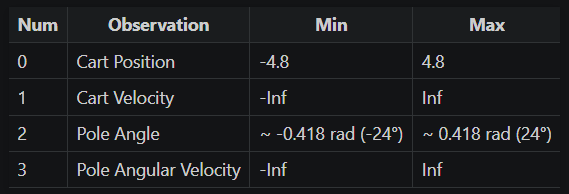

Note: While the ranges above denote the possible values for observation space of each element, it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:

* The cart x-position (index 0) can be take values between (-4.8, 4.8), but the episode terminates if the cart leaves the (-2.4, 2.4) range.

* The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode terminates if the pole angle is not in the range (-.2095, .2095) (or ±12°)

## Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05)

## Rewards

Since the goal is to keep the pole upright for as long as possible, by default, a reward of +1 is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

If sutton_barto_reward=True, then a reward of 0 is awarded for every non-terminating step and -1 for the terminating step. As a result, the reward threshold is 0 for v0 and v1.

## Action Space
The action is a ndarray with shape (1,) which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

* **0: Push cart to the left**
* **1: Push cart to the right**

Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

## Episode End

The episode ends if any one of the following occurs:

* **Termination:**: Pole Angle is greater than ±12°
* **Termination:**: Position is greater than ±2.4 (center of the cart reaches the edge of the display)
* **Truncation (when using the time_limit wrapper):**: Episode length is greater than 500 (200 for v0)




# Q-Learning Algorithm

Q-Learning is a model-free reinforcement learning algorithm that finds the optimal policy by interacting with the environment.

It updates the Q-value (state-action value function) using the Bellman equation for Q-values. For the exercise, we use a discount factor (gamma = 0.99), a learning rate (alpha = 0.5), and ran it for a fixed number of episodes (num_episodes = 50000).

Additionally using **epsilon-greedy exploration strategy**, which balances **exploration** we start with epsilon of 1 so it explores a lot at the start and we decay with 0.99995 to a minimun of 0.01 by taking the max of whiever is greater max(min_epsilon, epsilon * epsilon_decay)

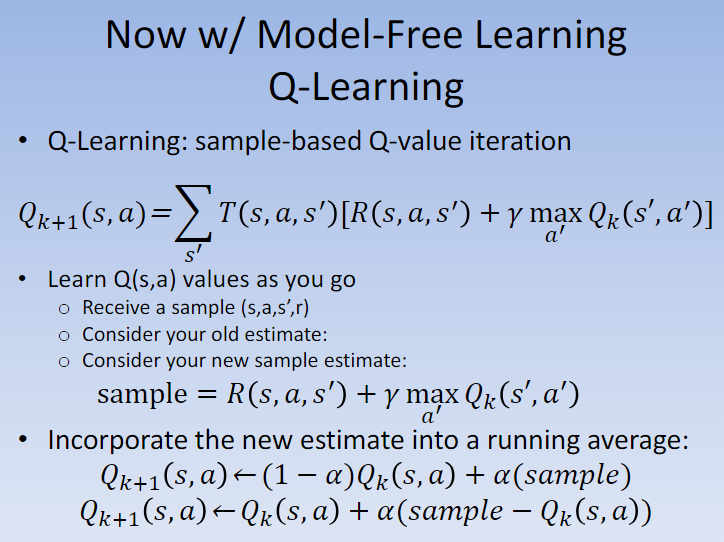

Steps:
- **Initialize** the Q-value function Q(s,a) for each state-action pair (s,a), often starting with zero for all states and actions.
- **Select actions** using an epsilon-greedy strategy, where with probability ϵ the agent explores a random action, and with 1 - ϵ it exploits the current best-known action.
- **Update the Q-value function** after taking each action using the following Q-Learning update rule:

    Q(s,a) = Q(s,a) + α[R(s,a,s') + γmax_aQ(s',a) - Q(s,a)]

    where R(s,a,s') is the reward received, and s' is the next state.

- **Repeat** the updates over multiple episodes until the Q-values converge, or until a sufficient number of episodes have been completed.
- **Extract the policy** from the Q-value function by choosing the action that maximizes the Q-value for each state:

    π*(s) = arg max_a  Q(s,a)


In [1]:
import gymnasium as gym
import numpy as np

def get_discrete_state(state, np_array_win_size):
    """
    Convert a continuous state into a discrete state using scaling and offset.
    
    Parameters:
        state: Continuous state from the environment.
        np_array_win_size: Array defining the scaling factor for each dimension.
        
    Returns:
        Tuple representing the discrete state.
    """
    discrete_state = state / np_array_win_size + np.array([15, 10, 1, 10])  # Offset values
    return tuple(discrete_state.astype(int))
# best weights so far env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_decay=0.99995 , min_epsilon=0.01, max_steps=100
def q_learning(env, num_episodes=50000, alpha=0.5, gamma=0.99, epsilon=1.0, epsilon_decay=0.99995 , min_epsilon=0.01, max_steps=100):
    """
    Perform basic Q-learning on the CartPole environment with discretized states.

    Parameters:
        env: Gymnasium environment (e.g., CartPole-v1)
        num_episodes: Number of episodes to train
        alpha: Learning rate
        gamma: Discount factor
        epsilon: Exploration rate
        epsilon_decay: Decay factor for epsilon after each episode
        min_epsilon: Minimum exploration rate
        max_steps: Maximum steps per episode.

    Returns:
        Q: Learned Q-table
        policy: Optimal policy derived from the Q-table
    """
    # Define the window size for each state dimension
    np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

    # Calculate the discrete state space size
    discrete_state_space_size = (30, 30, 50, 50)  # Number of discrete states (adjust as needed)
    n_actions = env.action_space.n

    # Initialize Q-table
    Q = np.zeros(discrete_state_space_size + (n_actions,))

    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset the environment
        discrete_state = get_discrete_state(state, np_array_win_size)  # Discretize the initial state
        total_reward = 0

        for step in range(max_steps):
            # Choose an action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(Q[discrete_state])  # Exploit: best known action

            # Take the action and observe the result
            next_state, reward, done, _, _ = env.step(action)
            next_discrete_state = get_discrete_state(next_state, np_array_win_size)

            # Update the Q-value using the Q-learning formula
            best_next_action = np.argmax(Q[next_discrete_state])
            td_target = reward + gamma * Q[next_discrete_state][best_next_action]
            td_error = td_target - Q[discrete_state][action]
            Q[discrete_state][action] += alpha * td_error

            discrete_state = next_discrete_state
            total_reward += reward

            if done:
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Debugging: Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    # Extract policy
    policy = np.argmax(Q, axis=-1)

    return Q, policy

In [2]:
# Create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Train the agent
Q, policy = q_learning(env)

env.close()

Episode 0, Total Reward: 37.0, Epsilon: 1.000
Episode 100, Total Reward: 9.0, Epsilon: 0.995
Episode 200, Total Reward: 17.0, Epsilon: 0.990
Episode 300, Total Reward: 11.0, Epsilon: 0.985
Episode 400, Total Reward: 22.0, Epsilon: 0.980
Episode 500, Total Reward: 14.0, Epsilon: 0.975
Episode 600, Total Reward: 33.0, Epsilon: 0.970
Episode 700, Total Reward: 24.0, Epsilon: 0.966
Episode 800, Total Reward: 18.0, Epsilon: 0.961
Episode 900, Total Reward: 35.0, Epsilon: 0.956
Episode 1000, Total Reward: 13.0, Epsilon: 0.951
Episode 1100, Total Reward: 12.0, Epsilon: 0.946
Episode 1200, Total Reward: 16.0, Epsilon: 0.942
Episode 1300, Total Reward: 16.0, Epsilon: 0.937
Episode 1400, Total Reward: 29.0, Epsilon: 0.932
Episode 1500, Total Reward: 20.0, Epsilon: 0.928
Episode 1600, Total Reward: 34.0, Epsilon: 0.923
Episode 1700, Total Reward: 16.0, Epsilon: 0.918
Episode 1800, Total Reward: 28.0, Epsilon: 0.914
Episode 1900, Total Reward: 43.0, Epsilon: 0.909
Episode 2000, Total Reward: 20.0,

In [3]:
# Evaluate student's solution (Optional)
def evaluate_policy(env, policy, np_array_win_size, num_episodes=100, max_steps=100):
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()  # Reset the environment
        done = False
        while not done:
            # Discretize the current state to use the policy
            discrete_state = get_discrete_state(state, np_array_win_size)
            action = policy[discrete_state]  # Get the action from the policy
            state, reward, done, _, _ = env.step(action)  # Take the action
            total_reward += reward
    return total_reward / num_episodes
# Create the environment
env = env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=3)

# Define the state discretization parameters (same as in training)
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

# Evaluate the learned policy
average_reward = evaluate_policy(env, policy, np_array_win_size)
print("Average Reward from Q-Learning Policy:", average_reward)

Average Reward from Q-Learning Policy: 805.42


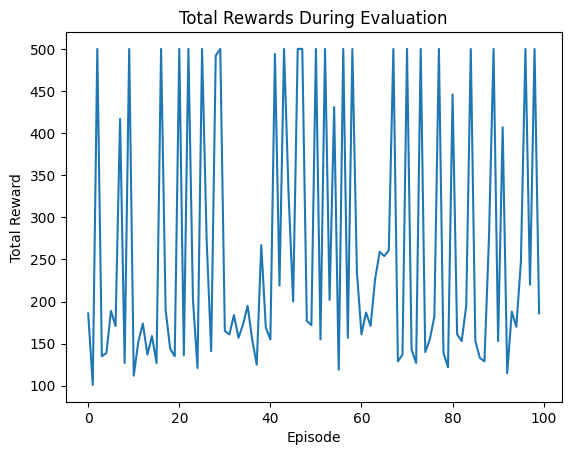

In [9]:
def evaluate_policy(env, policy, np_array_win_size, num_episodes=100, max_steps=500):
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            discrete_state = get_discrete_state(state, np_array_win_size)
            action = policy[discrete_state]  # Use the learned policy
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break
        total_rewards.append(total_reward)
    return total_rewards
# Evaluate the learned policy
num_eval_episodes = 100
env = env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=3)
# Define the state discretization parameters (same as in training)
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

eval_rewards = evaluate_policy(env, policy, np_array_win_size, num_episodes=num_eval_episodes)

# Plot total rewards
import matplotlib.pyplot as plt

plt.plot(range(len(eval_rewards)), eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards During Evaluation")
plt.show()
env.close()

# Agent playing the game using the Q-Learning policy

In [7]:
import gymnasium as gym
import numpy as np
# Create the environment
env = env = gym.make("CartPole-v1", render_mode="human")

np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])
# Reset the environment to the initial state
observation, info = env.reset(seed=42)
discrete_state = get_discrete_state(observation, np_array_win_size)
total_reward = 0

for _ in range(500):
    # Select the best action according to the learned policy
    action = np.argmax(Q[discrete_state])

    # Take the action
    observation, reward, terminated, truncated, info = env.step(action)
    discrete_state = get_discrete_state(observation, np_array_win_size)
    total_reward += reward

    # Render the environment
    env.render()

    if terminated or truncated:
        print(f"Game over! Total Reward: {total_reward}", truncated)
        total_reward = 0
        observation, info = env.reset()
env.close()

Game over! Total Reward: 500.0 True


# Approximate Q-Learning Algorithm

Approximate Q-Learning is a model-free reinforcement learning algorithm that uses a function approximator to estimate Q-values instead of a Q-table. It finds the optimal policy by iteratively adjusting the weights of the approximator based on observed rewards and state transitions.

It updates the Q-value (state-action value function) using the Bellman equation for Q-values. For the exercise, we use a discount factor (gamma = 0.95), a learning rate (alpha = 0.001), and ran it for a fixed number of episodes (num_episodes = 50000).

Additionally using **epsilon-greedy exploration strategy**, which balances **exploration** we start with epsilon of 1 so it explores a lot at the start and we decay with 0.99995 to a minimun of 0.01 by taking the max of whiever is greater max(min_epsilon, epsilon * epsilon_decay)

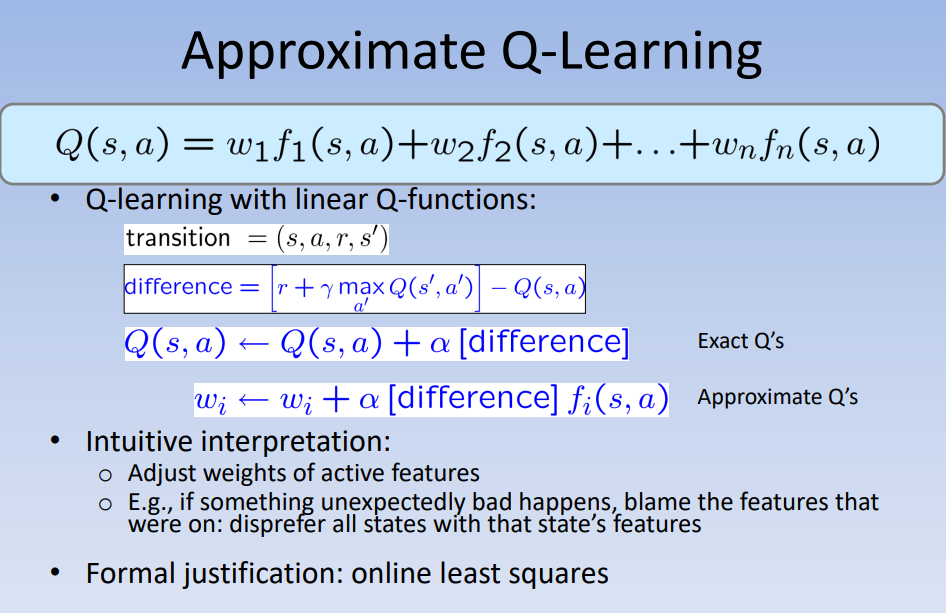

Steps:
- **Initialize the Weights** The function approximator is represented by a weight matrix 'w', initialized randomly or to small values. Each action has its own set of weights, corresponding to the features of the state space.

- **Select Actions Using Epsilon-Greedy** 
* For each state 's', select an action 'a':
    *  With probability ϵ, select a random action (explore).
    *  Otherwise, select the action that maximizes the approximated Q-value
- **Update the Weights** After taking an action 'a' and observing the reward 'r' and next state 's'', update the weights 'w' using the Temporal Difference (TD) update rule:

    TD Error (difference) = [r + γmax_a'Q(s',a')] - Q(s,a)
        w ← w + α * TD Error * f(s,a)
    This update minimizes the TD error [difference] by adjusting the weights 'w'

- **Repeat Over Episodes** the updates over multiple episodes until the Q-values converge, or until a sufficient number of episodes have been completed.
- **Policy Extraction** The optimal policy π*(s) is derived from the learned Q-value function by selecting the action with the highest estimated Q-value for each state:

    π*(s) = arg max_a  Q(s,a;w)

In [ ]:
import gymnasium as gym
import numpy as np
# best weights so far env, num_episodes=50000, alpha=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.99995, min_epsilon=0.01, max_steps=100
def approximate_q_learning(env, num_episodes=50000, alpha=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.99995, min_epsilon=0.01, max_steps=100):
    """
    Perform approximate Q-learning with a linear function approximator for continuous state spaces.

    Parameters:
        env: Gymnasium environment (e.g., CartPole-v1)
        num_episodes: Number of episodes to train
        alpha: Learning rate
        gamma: Discount factor (0 < gamma <= 1)
        epsilon: Exploration rate for ε-greedy policy
        epsilon_decay: Decay factor for epsilon after each episode
        min_epsilon: Minimum exploration rate
        max_steps: Maximum steps per episode.

    Returns:
        weights: Learned weights for the linear function approximator.
        q_value_fn: A function to compute Q(s, a) for any state and action.
        policy: A function that computes the best action for any given state.
    """
    n_features = env.observation_space.shape[0]  # Number of state features
    n_actions = env.action_space.n  # Number of possible actions

    # Initialize weights for the linear approximator
    weights = np.random.rand(n_features, n_actions)

    def q_value(state, action):
        """Compute Q(s, a) as a linear combination of state features."""
        return np.dot(state, weights[:, action])

    def best_action(state):
        """Return the action with the highest Q-value for a given state."""
        q_values = [q_value(state, a) for a in range(n_actions)]
        return np.argmax(q_values)

    # Main training loop
    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset environment and get initial state
        total_reward = 0

        for step in range(max_steps):
            # Choose an action using ε-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = best_action(state)  # Exploit
            
            # Take the action and observe the result
            next_state, reward, done, _, _ = env.step(action)

            # Compute the TD target
            best_next_action = best_action(next_state)
            td_target = reward + gamma * q_value(next_state, best_next_action)

            # Compute the TD error
            td_error = td_target - q_value(state, action)

            # Update weights
            weights[:, action] += alpha * td_error * state

            # Move to the next state
            state = next_state
            total_reward += reward

            if done:
                break
        # Decay epsilon after each episode
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Debugging: Print progress every 1000 episodes
        if episode % 1000 == 0:
            print(f"Episode {episode}, Epsilon: {epsilon:.3f}")

    return weights, q_value, best_action


In [143]:
# Create the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Apply Approximate Q-learning
weights, q_value_fn, best_action_fn = approximate_q_learning(env)

# Print weights for debugging
print("Learned Weights:")
print(weights)
env.close()

Episode 0, Epsilon: 1.000
Episode 1000, Epsilon: 0.951
Episode 2000, Epsilon: 0.905
Episode 3000, Epsilon: 0.861
Episode 4000, Epsilon: 0.819
Episode 5000, Epsilon: 0.779
Episode 6000, Epsilon: 0.741
Episode 7000, Epsilon: 0.705
Episode 8000, Epsilon: 0.670
Episode 9000, Epsilon: 0.638
Episode 10000, Epsilon: 0.606
Episode 11000, Epsilon: 0.577
Episode 12000, Epsilon: 0.549
Episode 13000, Epsilon: 0.522
Episode 14000, Epsilon: 0.497
Episode 15000, Epsilon: 0.472
Episode 16000, Epsilon: 0.449
Episode 17000, Epsilon: 0.427
Episode 18000, Epsilon: 0.407
Episode 19000, Epsilon: 0.387
Episode 20000, Epsilon: 0.368
Episode 21000, Epsilon: 0.350
Episode 22000, Epsilon: 0.333
Episode 23000, Epsilon: 0.317
Episode 24000, Epsilon: 0.301
Episode 25000, Epsilon: 0.286
Episode 26000, Epsilon: 0.273
Episode 27000, Epsilon: 0.259
Episode 28000, Epsilon: 0.247
Episode 29000, Epsilon: 0.235
Episode 30000, Epsilon: 0.223
Episode 31000, Epsilon: 0.212
Episode 32000, Epsilon: 0.202
Episode 33000, Epsilon:

In [144]:
# Evaluate student's solution (Optional)
def evaluate_approx_policy(env, best_action_fn, num_episodes=100):
    total_reward = 0
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = best_action_fn(state) 
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
    return total_reward / num_episodes
# Create the environment
num_eval_episodes = 100
env = env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=3)

average_reward = evaluate_approx_policy(env, best_action_fn, num_episodes=num_eval_episodes )
print("Average Reward from Approx Q-Learning Policy:", average_reward)

Average Reward from Approx Q-Learning Policy: 83.3


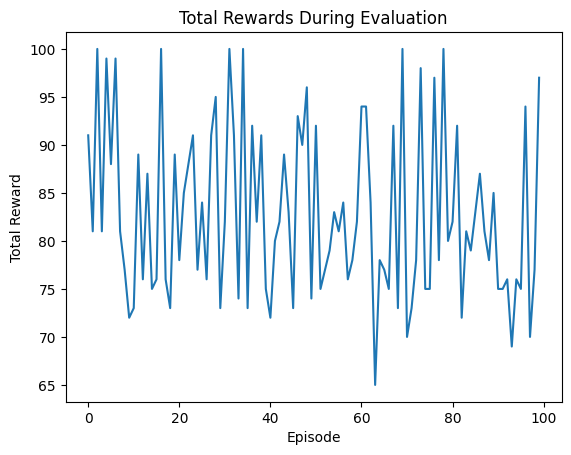

In [145]:
def evaluate_approx_policy(env, best_action_fn, num_episodes=100, max_steps=100):
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = best_action_fn(state)  # Use the learned policy
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break
        total_rewards.append(total_reward)
    return total_rewards
# Evaluate the learned policy
num_eval_episodes = 100
env = env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=3)
eval_rewards = evaluate_approx_policy(env, best_action_fn, num_episodes=num_eval_episodes)

# Plot total rewards
import matplotlib.pyplot as plt

plt.plot(range(len(eval_rewards)), eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards During Evaluation")
plt.show()
env.close()

# Agent playing the game using the Approx Q-Learning policy

In [146]:
import gymnasium as gym
import numpy as np
# Create the environment
env = env = gym.make("CartPole-v1", render_mode="human")

# Reset the environment to the initial state
observation, info = env.reset(seed=3)
total_reward = 0

for _ in range(500):
    # Select the best action according to the learned policy
    action = best_action_fn(observation)

    # Take the action
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    # Render the environment
    env.render()

    if terminated or truncated:
        print(f"Game over! Total Reward: {total_reward}", truncated)
        total_reward = 0
        observation, info = env.reset()
env.close()

Game over! Total Reward: 79.0 False
Game over! Total Reward: 91.0 False
Game over! Total Reward: 81.0 False
Game over! Total Reward: 111.0 False
Game over! Total Reward: 81.0 False
